In [2]:
#!git clone https://github.com/rajanlab/CURBD.git
import os 

In [3]:
import numpy as np
import numpy.random as npr
import pylab
import curbd
import math

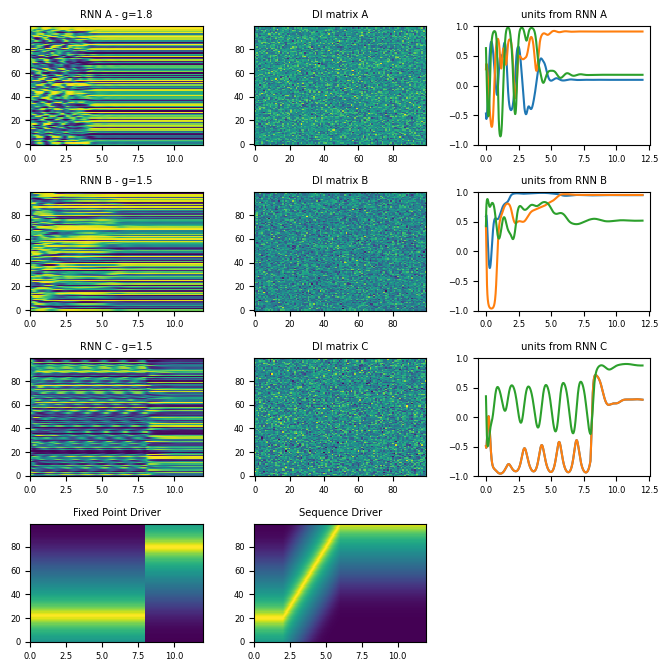

c:\Users\Andrew\Documents\MAT 6215\CURBD\curbd.py:548: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


In [4]:
sim = curbd.threeRegionSim(number_units=100)

In [5]:
sim.keys()

dict_keys(['Ra', 'Rb', 'Rc', 'Rseq', 'Rfp', 'tData', 'Ja', 'Jb', 'Jc', 'w_A2B', 'w_A2C', 'w_B2A', 'w_B2C', 'w_C2A', 'w_C2B', 'w_Fix2C', 'w_Seq2B', 'params'])

In [6]:
#three regions with each region having 100 units and 1201 time series data
activity = np.concatenate((sim['Ra'], sim['Rb'], sim['Rc']), 0) #300 x 1201
print (activity.shape)


(300, 1201)


In [7]:
Na = sim['params']['Na']
Nb = sim['params']['Nb']
Nc = sim['params']['Nc']

In [8]:
Na, Nb, Nc

(100, 100, 100)

In [9]:
regions = []
regions.append(['Region A', np.arange(0, Na)])
regions.append(['Region B', np.arange(Na, Na + Nb)])
regions.append(['Region C', np.arange(Na + Nb, Na + Nb + Nc)])
regions = np.array(regions, dtype=object)

regions

array([['Region A',
        array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
               17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
               34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
               51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
               68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84,
               85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99])       ],
       ['Region B',
        array([100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112,
               113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125,
               126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138,
               139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151,
               152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164,
               165, 166, 167, 168, 169, 170, 171, 172, 173, 

# Initializing the parameters 

In [ ]:
dtData=sim['params']['dtData'] # time step of training data
dtFactor=5 # number of interpolation steps for RNN 
regions=regions # number of regions and names of the regions
tauRNN=2*sim['params']['tau']/2 # decay constant of RNN 
nRunTrain=10 # number of training runs
verbose=True
nRunFree=5 #number of untrained runs at end

g=1.5 # instability constant 
tauWN=0.1 #decay constant on filtered white noise inputs
ampInWN=0.01 #input amplitude of filtered white noise 
P0=1.0 #learning rate 
nonLinearity=np.tanh
nonLinearity_inv=np.arctanh
resetPoints=None
plotStatus=True
regions=None



In [ ]:
if dtData is None: #0.01
    print('dtData not specified. Defaulting to 1.');
    dtData = 1;
if resetPoints is None:
    resetPoints = [0, ]
if regions is None:
    regions = {}

In [ ]:
number_units = activity.shape[0] #300 -- the total number of units 
number_learn = activity.shape[0] #300

dtRNN = dtData / float(dtFactor) # 0.01/5=0.002
nRunTot = nRunTrain + nRunFree #10+5=15


In [ ]:
learnList = npr.permutation(number_units) #randomize the units
iTarget = learnList[:number_learn]
iNonTarget = learnList[number_learn:] # []

tData = dtData*np.arange(activity.shape[1]) #   [0, 0.01, 0.02 ....,12.01] #1201 input time steps 
tRNN = np.arange(0, tData[-1] + dtRNN, dtRNN) # [0, 0.002, 0.004 ...., 12.01] #6000 rnn time steps


# print("learnList : ",learnList)
# print("iTarget: ",iTarget)
# print("iNonTarget : ",iNonTarget)
# print("tData: ",tData)
# print("tRNN: ",tRNN)

# External Input to RNN

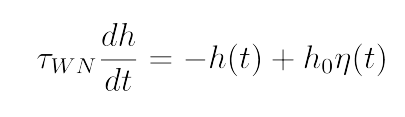

In [ ]:
ampWN = math.sqrt(tauWN/dtRNN) # (0.1/0.002)
iWN = ampWN * npr.randn(number_units, len(tRNN)) #gaussian noise ? #300x6001
inputWN = np.ones((number_units, len(tRNN))) #300x6001
# print("inputWN : ",inputWN)
for tt in range(1, len(tRNN)):
    inputWN[:, tt] = iWN[:, tt] + (inputWN[:, tt - 1] - iWN[:, tt])*np.exp(- (dtRNN / tauWN)) # solve the above differential equation 
inputWN = ampInWN * inputWN # external input h(t)

# print("ampWN : ",ampWN)
# print("iWN : ",iWN)
# print("inputWN",inputWN)


# Initialize weight matrix J

In [ ]:
J = g * npr.randn(number_units, number_units) / math.sqrt(number_units) # g<1 -> damped and g>1 -> chaotic
J0 = J.copy()
# print ('J0 : ',J0)
print (J0.shape)

(300, 300)


# Set up target training data

In [ ]:
Adata = activity.copy()
Adata = Adata/Adata.max()
Adata = np.minimum(Adata, 0.999) # elementwise minimum 
Adata = np.maximum(Adata, -0.999) # elementwise max

# print ("Adata : ",Adata)
print (Adata.shape)

(300, 1201)


In [ ]:
# get standard deviation of entire data
stdData = np.std(Adata[iTarget, :])

# Get indices for each sample of model data

In [ ]:
iModelSample = np.zeros(len(tData), dtype=np.int32)
print ("iModelSample : ",iModelSample)
for i in range(len(tData)):
    iModelSample[i] = (np.abs(tRNN - tData[i])).argmin()

# print("iModelSample : ",iModelSample)
print (iModelSample.shape)

iModelSample :  [0 0 0 ... 0 0 0]
(1201,)


In [ ]:
RNN = np.zeros((number_units, len(tRNN))) # 300 X 6001
chi2s = []
pVars = []
# 3 RNNs with 100 units is trained with 6001 rnn steps

In [ ]:
PJ = P0*np.eye(number_learn) #P0=learning rate 
# print ("PJ : ",PJ)
print (PJ.shape)

(300, 300)


# Start Training

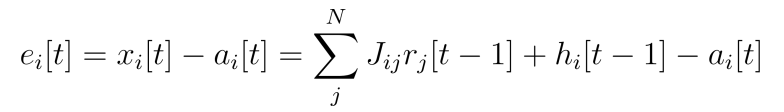

In [ ]:
# loop along training runs
nRunTot = 1
for nRun in range(0, nRunTot):
    H = Adata[:, 0, np.newaxis] # 300 X 1
    RNN[:, 0, np.newaxis] = nonLinearity(H)
    # variables to track when to update the J matrix since the RNN and
    # data can have different dt values
    tLearn = 0  # keeps track of current time
    iLearn = 0  # keeps track of last data point learned
    chi2 = 0.0
    break

    for tt in range(1, len(tRNN)): # 300 
        # update current learning time
        tLearn += dtRNN
        # check if the current index is a reset point. Typically this won't
        # be used, but it's an option for concatenating multi-trial data
        if tt in resetPoints:
            timepoint = math.floor(tt / dtFactor)
            H = Adata[:, timepoint]
        # compute next RNN step
        RNN[:, tt, np.newaxis] = nonLinearity(H) # calculate the non linearity 
        JR = (J.dot(RNN[:, tt]).reshape((number_units, 1)) +
              inputWN[:, tt, np.newaxis]) # Calculate the dot product JR + External Input 
        H = H + dtRNN*(-H + JR)/tauRNN 
        # check if the RNN time coincides with a data point to update J
        if tLearn >= dtData:
            tLearn = 0
            err = RNN[:, tt, np.newaxis] - Adata[:, iLearn, np.newaxis]
            iLearn = iLearn + 1
            # update chi2 using this error
            chi2 += np.mean(err ** 2)

            if nRun < nRunTrain:
                r_slice = RNN[iTarget, tt].reshape(number_learn, 1)
                k = PJ.dot(r_slice)
                rPr = (r_slice).T.dot(k)[0, 0]
                c = 1.0/(1.0 + rPr)
                PJ = PJ - c*(k.dot(k.T))
                J[:, iTarget.flatten()] = J[:, iTarget.reshape((number_units))] - c*np.outer(err.flatten(), k.flatten())

    rModelSample = RNN[iTarget, :][:, iModelSample]
    distance = np.linalg.norm(Adata[iTarget, :] - rModelSample)
    pVar = 1 - (distance / (math.sqrt(len(iTarget) * len(tData))
                * stdData)) ** 2
    pVars.append(pVar)
    chi2s.append(chi2)

(300, 1)
300
haha
